<a href="https://colab.research.google.com/github/DiegoMBrito/MVP_Sprint2/blob/main/DP/Modelos_h5/MVP_Sprint2_DP_Comentada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Definição do projeto

 Este projeto tem como foco a Classificação de amostras geológicas por meio de imagens utilizando o modelos de aprendizado de máquina. O objetivo principal é avaliar a eficácia e precisão das redes neurais utilizdas (CNN, Resnet50 e InceptionV3) na identificação de diferentes tipos de estruturas contidas em rochas. Esse estudo busca auxiliar profissionais no reconhecimento de estruturas geológicas assim como também fornecer conclusões relevantes sobre a aplicação de inteligência artificial em geologia e ciências da terra.

## 1. Importando e instalando algumas bibliotecas necessárias para executação deste notebook.

In [29]:
# ! pip install tensorflow

# ! pip install keras

# ! pip install pandas

# ! pip install scikit-learn

# ! pip install wget

In [91]:
# Importações de libs necessárias

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import wget
import zipfile
import requests

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras import regularizers

from sklearn.model_selection import KFold

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from PIL import Image

## 2. Baixando e tratando os dados que serão usados como entrada para os modelos de Deep Learning.

In [31]:
# Especifique a URL do arquivo ZIP contendo o diretório
url = 'https://raw.githubusercontent.com/DiegoMBrito/MVP_Sprint2/main/DP/data/Classes_Structures.zip'

# Baixe o arquivo ZIP
wget.download(url, 'Classes_Structures.zip')

# Extraia o arquivo ZIP
with zipfile.ZipFile('Classes_Structures.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [32]:
# Definir caminhos dos diretórios de treino, validação e teste que estão no github
diretorio_treino = 'Classes_Structures/Train'
diretorio_validacao = 'Classes_Structures/Validation'
diretorio_teste = 'Classes_Structures/Test'

In [33]:
# Definir o tamanho das imagens e o número de classes
input_shape = (256, 256, 3)
num_classes = 9

In [34]:
# Definir os hiperparâmetros do treinamento
batch_size = 128
epochs = 100

In [35]:
# Definir o data augmentation para imagens de treinamento
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Usar o ImageDataGenerator normal (sem data augmentation) para imagens de validação e teste
validation_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen = ImageDataGenerator(rescale=1.0/255)


##### Preparação dos dados usando o 'ImageDataGenerator'

Que é uma classe da biblioteca Keras que permite gerar lotes de imagens aumentadas (augmented images) em tempo real durante o treinamento de modelos de aprendizado profundo. O objetivo principal do 'ImageDataGenerator' é aumentar a quantidade de dados de treinamento disponíveis, melhorando a capacidade de generalização do modelo e reduzindo o risco de overfitting. O aumento de dados envolve a aplicação de transformações aleatórias nas imagens existentes, como rotação, translação, zoom, espelhamento horizontal, alteração de brilho, entre outras técnicas.

In [36]:
# Definir o gerador de dados para as imagens de treinamento
train_generator = train_datagen.flow_from_directory(
    diretorio_treino,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    diretorio_validacao,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    diretorio_teste,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1310 images belonging to 9 classes.
Found 360 images belonging to 9 classes.
Found 135 images belonging to 9 classes.


## 3.  Configuração dos modelos de Deep Learning

Será realizado o treinamento com 3 modelos diferentes, a Deep CNN, Resnet50 e InceptionV3. O modelo como melhor resultado de acurácia será usado para classificar as imagens de teste.

### Modelo CNN Profunda

Aqui é especificada uma camada convolucional 2D que possui 32 filtros no inicio, sobe até 256 e volta para 32, um tamanho de filtro de 3x3 que usa a função de ativação ReLU. O parâmetro input_shape define a forma das imagens de entrada para a rede. Na sequência são adicionadas camadas max-pooling 2X2 com a mesma função de ativação. Também foi adicionado uma taxa Dropout com valor de 0.25. Para finalizar a rede, estou usando a função Softmax.

In [38]:
# Carregar o modelo CNN Profunda e adicionar as camadas personalizadas

cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(input_shape)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu',))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu',))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(256, (3, 3), activation='relu',))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu',))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu',))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(32, activation='relu',))
tf.keras.layers.Dropout(0.25),
cnn_model.add(Dense(num_classes, activation='softmax'))

 O método summary() é usado para exibir um resumo da arquitetura do modelo de rede neural. Ele fornece uma representação compacta das camadas do modelo e seus parâmetros, incluindo o número de parâmetros treináveis e a forma de saída de cada camada.

In [39]:
# Exibir o resumo do modelo
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 30, 30, 128)     

## 3.1 Treinamento do modelo CNN Profunda

Nesse modelo foi usado o otimizador Adam; com uma taxa de aprendizado de 0.001; para a função de perda, foi escolhida a função Categorical_crossentropy; e como métrica foi específicado a Acurácia.

In [40]:
# Compilar o modelo CNN com o otimizador Adam configurado com a taxa de aprendizado
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
# Criar o callback para visualização das imagens durante o treinamento
tensorboard_callback = TensorBoard(log_dir='./logs')

In [42]:
# Treinar o modelo CNN apenas com os dados de treino
history_cnn = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
10/10 [==============================] - 11s 919ms/step - loss: 2.1994 - accuracy: 0.1252 - val_loss: 2.1836 - val_accuracy: 0.0781
Epoch 2/100
10/10 [==============================] - 9s 929ms/step - loss: 2.1682 - accuracy: 0.1684 - val_loss: 2.1003 - val_accuracy: 0.2461
Epoch 3/100
10/10 [==============================] - 13s 1s/step - loss: 2.1429 - accuracy: 0.1672 - val_loss: 2.0457 - val_accuracy: 0.2656
Epoch 4/100
10/10 [==============================] - 12s 1s/step - loss: 2.0739 - accuracy: 0.1904 - val_loss: 1.9860 - val_accuracy: 0.2539
Epoch 5/100
10/10 [==============================] - 13s 1s/step - loss: 2.0614 - accuracy: 0.1954 - val_loss: 1.9847 - val_accuracy: 0.2656
Epoch 6/100
10/10 [==============================] - 12s 1s/step - loss: 2.0405 - accuracy: 0.2047 - val_loss: 1.9633 - val_accuracy: 0.2812
Epoch 7/100
10/10 [==============================] - 13s 1s/step - loss: 2.0216 - accuracy: 0.2090 - val_loss: 1.9302 - val_accuracy: 0.2930
Epoch 8/

Visualização dos gráficos com resultados da acurácia e perda do modelo para o conjunto de treino e validação.

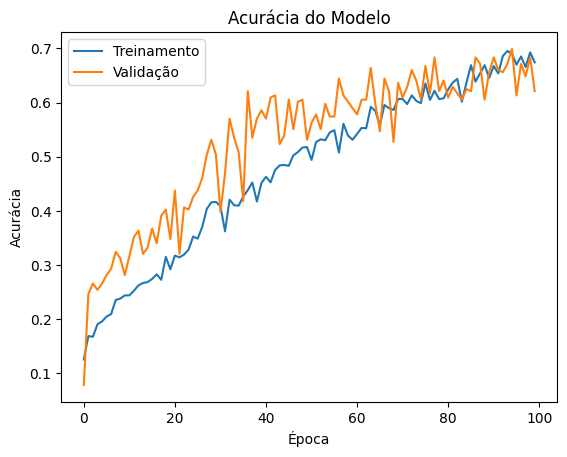

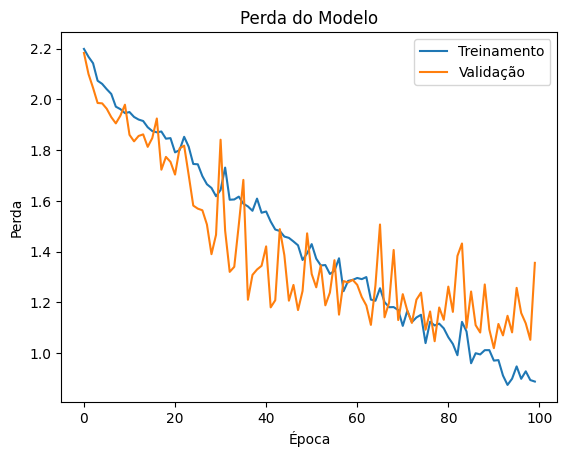

In [43]:
# Plotar a acurácia e a perda durante o treinamento
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()

plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.show()

In [48]:
# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = cnn_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Acurácia no conjunto de teste:', test_accuracy)

1/1 [==============================] - 1s 605ms/step - loss: 1.2014 - accuracy: 0.6328
Acurácia no conjunto de teste: 0.6328125


O modelo CNN Profunda mostrou um resultado mediano para o conjunto de teste com acuária de 63,28%. Esse foi o melhor resultado encontrado mesmo variando as configurações dos hiperparãemtros do modelo.

In [98]:
# Salvar o modelo CNN Profunda
#cnn_model.save('https://raw.githubusercontent.com/DiegoMBrito/MVP_Sprint2/main/DP/data/Modelos_h5/DeepCNN.h5')

# Defina o URL do repositório do GitHub e o caminho para salvar o arquivo
github_url = 'https://github.com/DiegoMBrito/MVP_Sprint2/blob/main/DP/data/Modelos_h5/cnn_model.h5'
file_path = 'GitHub/MVP_Sprint2/DP/Modelos_h5'

# Carregue o arquivo localmente
cnn_model.save('GitHub/MVP_Sprint2/DP/Modelos_h5/cnn_model.h5')

### Modelo Resnet50

A configuração das camadas começa com a camada GlobalAveragePooling2D, passando para as camadas densas, começando com uma de 1024 neurônios e diminuindo até 32 neurônios para chegar próximo ao número de saída, 9 neurônios, representando cada uma das classes de estruturas, todas Dense. Ambas usando a função de reativação 'relu' no final de cada camada intermediária. Foi usado o Dropout com taxa de 0.35 também, que é uma técnica eficaz para combater o overfitting, fornecendo uma regularização interna durante o treinamento da rede neural. E para finalizar  as camadas, foi usado a função de reativação 'softmax', pois esse estudo se trata de uma classificação multiclasse.

In [66]:
# Carregue o modelo ResNet50 pré-treinado (sem incluir as camadas totalmente conectadas no topo)
Resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Congele as camadas do modelo base para que elas não sejam treinadas novamente
Resnet_model.trainable = False

In [67]:
# Crie o modelo final, adicionando camadas personalizadas no topo do modelo base
Resnet_model = tf.keras.models.Sequential([
    Resnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

 O método summary() é usado para exibir um resumo da arquitetura do modelo de rede neural. Ele fornece uma representação compacta das camadas do modelo e seus parâmetros, incluindo o número de parâmetros treináveis e a forma de saída de cada camada.

In [68]:
# Exibir o resumo do modelo
Resnet_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_25 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_26 (Dense)            (None, 512)               524800    
                                                                 
 dense_27 (Dense)            (None, 256)               131328    
                                                                 
 dense_28 (Dense)            (None, 128)               32896     
                                                      

## 3.2 Treinamento do modelo Resnet50

Nesse modelo foi usado o otimizador Adam; com uma taxa de aprendizado de 0.001; para a função de perda, foi escolhida a função Categorical_crossentropy; e como métrica foi específicado a Acurácia.

In [69]:
# Compile o modelo
Resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [70]:
# Criar o callback para visualização das imagens durante o treinamento
tensorboard_callback = TensorBoard(log_dir='./logs')

In [71]:
# Treinar o modelo e armazenar o histórico
history_Resnet50 = Resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
10/10 [==============================] - 13s 1s/step - loss: 2.2391 - accuracy: 0.1159 - val_loss: 2.2178 - val_accuracy: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 11s 1s/step - loss: 2.2039 - accuracy: 0.0990 - val_loss: 2.1873 - val_accuracy: 0.1719
Epoch 3/100
10/10 [==============================] - 11s 1s/step - loss: 2.2063 - accuracy: 0.1024 - val_loss: 2.1768 - val_accuracy: 0.1641
Epoch 4/100
10/10 [==============================] - 11s 1s/step - loss: 2.1997 - accuracy: 0.1066 - val_loss: 2.1901 - val_accuracy: 0.2305
Epoch 5/100
10/10 [==============================] - 12s 1s/step - loss: 2.1969 - accuracy: 0.1176 - val_loss: 2.1739 - val_accuracy: 0.1562
Epoch 6/100
10/10 [==============================] - 9s 912ms/step - loss: 2.1956 - accuracy: 0.1117 - val_loss: 2.1854 - val_accuracy: 0.0938
Epoch 7/100
10/10 [==============================] - 9s 954ms/step - loss: 2.1949 - accuracy: 0.1024 - val_loss: 2.1814 - val_accuracy: 0.1484
Epoch

Visualização dos gráficos com resultados da acurácia e perda do modelo para o conjunto de treino e validação.

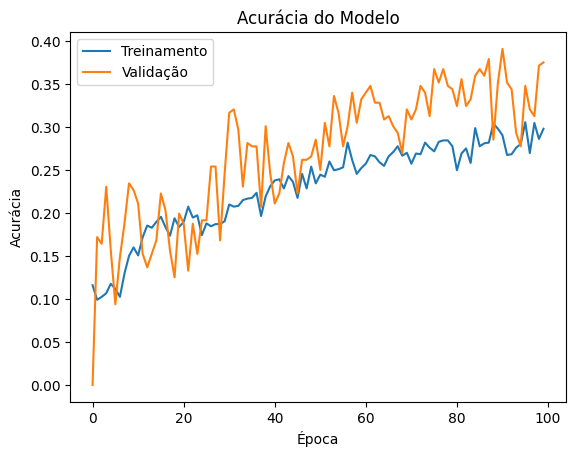

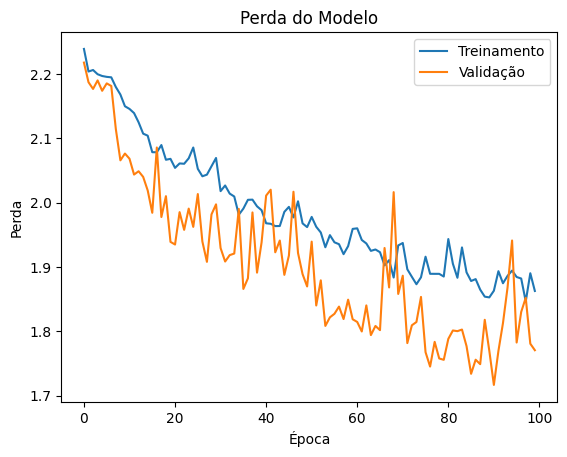

In [72]:
# Plotar a acurácia e a perda durante o treinamento
plt.plot(history_Resnet50.history['accuracy'])
plt.plot(history_Resnet50.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()

plt.plot(history_Resnet50.history['loss'])
plt.plot(history_Resnet50.history['val_loss'])
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.show()

In [73]:
# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = Resnet_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Acurácia no conjunto de teste:', test_accuracy)

1/1 [==============================] - 1s 522ms/step - loss: 1.8667 - accuracy: 0.2344
Acurácia no conjunto de teste: 0.234375


In [99]:
# Salvar o modelo Resnet
# Resnet_model.save('https://raw.githubusercontent.com/DiegoMBrito/MVP_Sprint2/main/DP/data/Modelos_h5/Resnet.h5')

# Defina o URL do repositório do GitHub e o caminho para salvar o arquivo
github_url = 'https://github.com/DiegoMBrito/MVP_Sprint2/blob/main/DP/data/Modelos_h5/Resnet_model.h5'
file_path = 'GitHub/MVP_Sprint2/DP/Modelos_h5'

# Carregue o arquivo localmente
cnn_model.save('GitHub/MVP_Sprint2/DP/Modelos_h5/Resnet_model.h5')

O modelo Resnet50 mostrou um resultado muito baixo para o conjunto de teste com acuária de 23,44%. Esse foi o melhor resultado encontrado mesmo variando as configurações dos hiperparãemtros do modelo.

### Modelo InceptionV3

A configuração das camadas começa com a camada GlobalAveragePooling2D, passando para as camadas densas, começando com uma de 1024 neurônios e diminuindo até 32 neurônios para chegar próximo ao número de saída, 9 neurônios, representando cada uma das classes de estruturas, todas Dense. Ambas usando a função de reativação 'relu' no final de cada camada intermediária. Foi usado o Dropout com taxa de 0.35 também, que é uma técnica eficaz para combater o overfitting, fornecendo uma regularização interna durante o treinamento da rede neural. E para finalizar  as camadas, foi usado a função de reativação 'softmax', pois esse estudo se trata de uma classificação multiclasse.

In [75]:
# Carregar o modelo InceptionV3 pré-treinado, usando os pesos da Imagenet e informado o tamanho das imagens.
Inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar todas as camadas do modelo base
for layer in Inception_model.layers:
    layer.trainable = False

In [76]:
# Crie o modelo final, adicionando camadas personalizadas no topo do modelo base
Inception_model = tf.keras.models.Sequential([
    Inception_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [77]:
# Exibir o resumo do modelo
Inception_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_32 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_33 (Dense)            (None, 512)               524800    
                                                                 
 dense_34 (Dense)            (None, 256)               131328    
                                                                 
 dense_35 (Dense)            (None, 128)               32896     
                                                      

## 3.3 Treinamento do modelo InceptionV3
Nesse modelo foi usado o otimizador Adam; com uma taxa de aprendizado de 0.001; para a função de perda, foi escolhida a função Categorical_crossentropy; e como métrica foi específicado a Acurácia.

In [78]:
# Compilar o modelo
Inception_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [79]:
# Criar o callback para visualização das imagens durante o treinamento
tensorboard_callback = TensorBoard(log_dir='./logs')

In [80]:
# Treinar o modelo e armazenar o histórico
history_Inception = Inception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
10/10 [==============================] - 15s 1s/step - loss: 2.2464 - accuracy: 0.1201 - val_loss: 2.1837 - val_accuracy: 0.0938
Epoch 2/100
10/10 [==============================] - 9s 837ms/step - loss: 2.1588 - accuracy: 0.1624 - val_loss: 2.1353 - val_accuracy: 0.1523
Epoch 3/100
10/10 [==============================] - 9s 837ms/step - loss: 2.0821 - accuracy: 0.2030 - val_loss: 2.0458 - val_accuracy: 0.3555
Epoch 4/100
10/10 [==============================] - 9s 848ms/step - loss: 2.0032 - accuracy: 0.2276 - val_loss: 1.8935 - val_accuracy: 0.3477
Epoch 5/100
10/10 [==============================] - 9s 845ms/step - loss: 1.8634 - accuracy: 0.3080 - val_loss: 1.6892 - val_accuracy: 0.5234
Epoch 6/100
10/10 [==============================] - 8s 831ms/step - loss: 1.7797 - accuracy: 0.3536 - val_loss: 1.4642 - val_accuracy: 0.5508
Epoch 7/100
10/10 [==============================] - 8s 830ms/step - loss: 1.6945 - accuracy: 0.3900 - val_loss: 1.4082 - val_accuracy: 0.5977
E

Visualização dos gráficos com resultados da acurácia e perda do modelo para o conjunto de treino e validação.

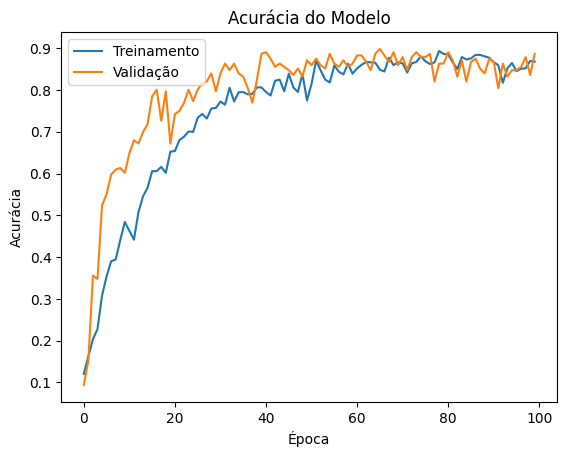

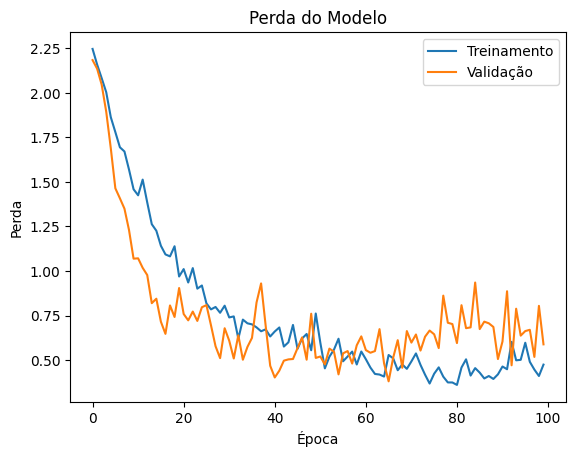

In [81]:
# Plotar a acurácia e a perda durante o treinamento
plt.plot(history_Inception.history['accuracy'])
plt.plot(history_Inception.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()

plt.plot(history_Inception.history['loss'])
plt.plot(history_Inception.history['val_loss'])
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.show()

In [82]:
# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = Inception_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Acurácia no conjunto de teste:', test_accuracy)

1/1 [==============================] - 0s 394ms/step - loss: 0.4633 - accuracy: 0.9219
Acurácia no conjunto de teste: 0.921875


O modelo InceptionV3 apresentou um bom resultado para o conjunto de teste com acuária de 92,19%. Esse foi o melhor resultado encontrado mesmo variando as configurações dos hiperparãemtros do modelo. Também foi o melhor resutlado entre os 3 modelos testados.

In [100]:
# Salvar o modelo InceptionV3
# Inception_model.save('https://raw.githubusercontent.com/DiegoMBrito/MVP_Sprint2/main/DP/data/Modelos_h5/InceptionV3.h5')

# Defina o URL do repositório do GitHub e o caminho para salvar o arquivo
github_url = 'https://github.com/DiegoMBrito/MVP_Sprint2/blob/main/DP/data/Modelos_h5/Inception_model.h5'
file_path = 'GitHub/MVP_Sprint2/DP/Modelos_h5'

# Carregue o arquivo localmente
cnn_model.save('GitHub/MVP_Sprint2/DP/Modelos_h5/Inception_model.h5')

4/4 [==============================] - 1s 37ms/step


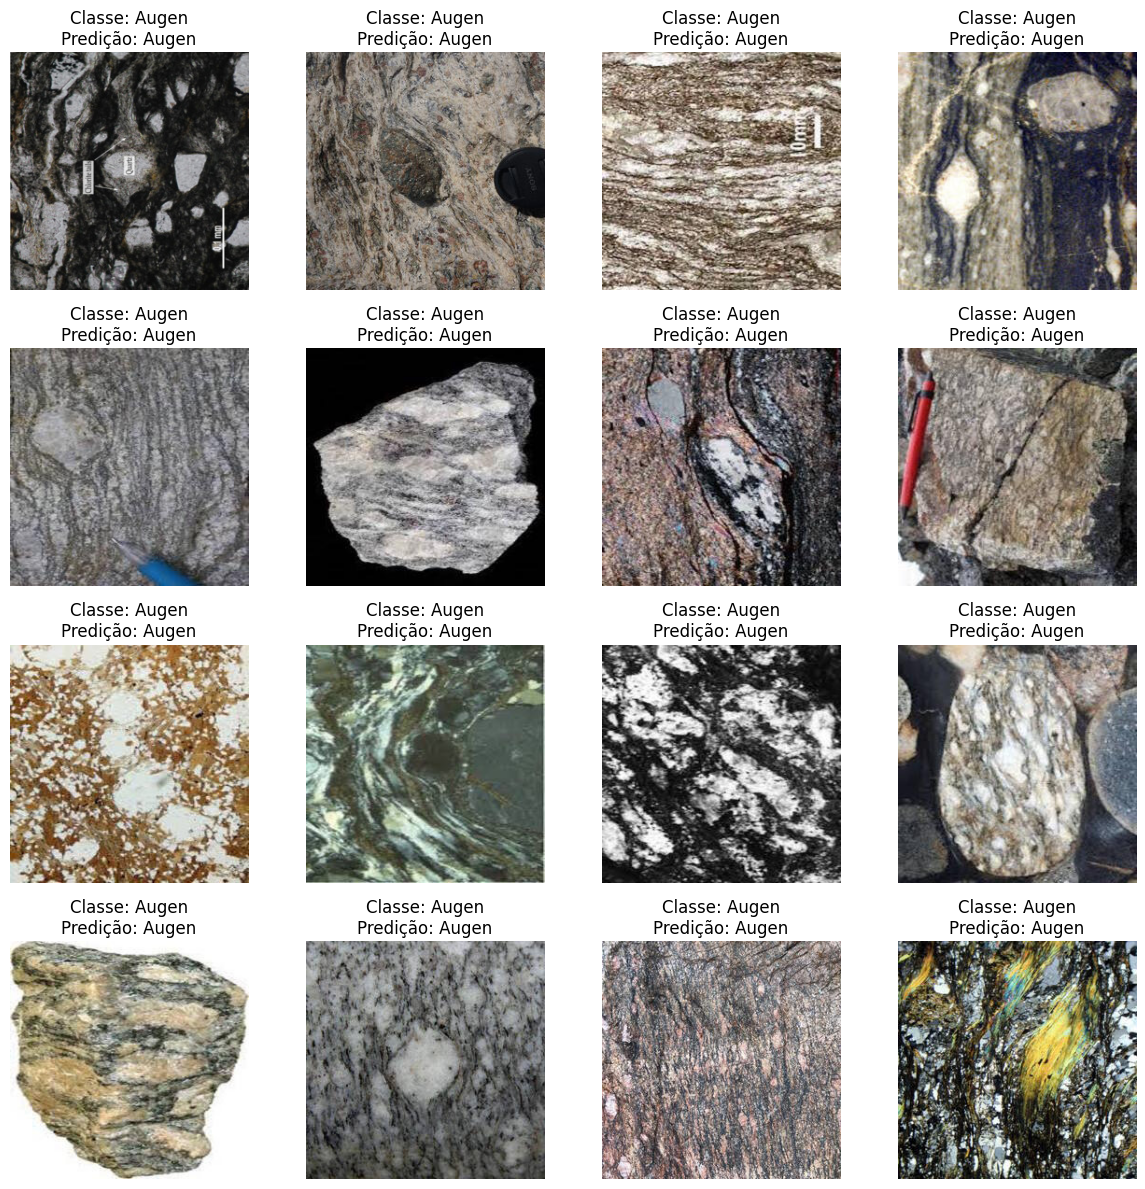

In [84]:
# Visualizar algumas imagens do conjunto de validação e suas classes
class_names = sorted(validation_generator.class_indices.keys())
images, labels = next(validation_generator)
predicted_labels = Inception_model.predict(images)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img = images[i]
    label = np.argmax(labels[i])
    predicted_label = np.argmax(predicted_labels[i])

    ax.imshow(img)
    ax.set_title(f'Classe: {class_names[label]}\nPredição: {class_names[predicted_label]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [85]:
# Fazer previsões nas imagens de teste
predictions = Inception_model.predict(test_generator)

# Obter as classes preditas para cada imagem
predicted_classes = np.argmax(predictions, axis=1)

# Obter as classes reais para cada imagem
true_classes = test_generator.classes

# Obter os rótulos das classes
class_labels = list(test_generator.class_indices.keys())

2/2 [==============================] - 2s 492ms/step


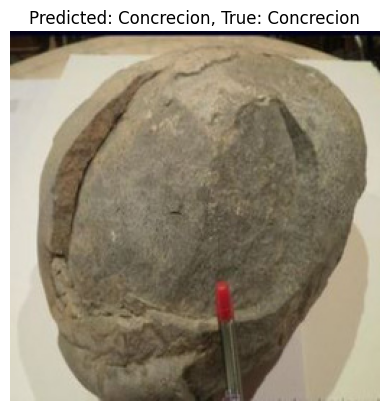

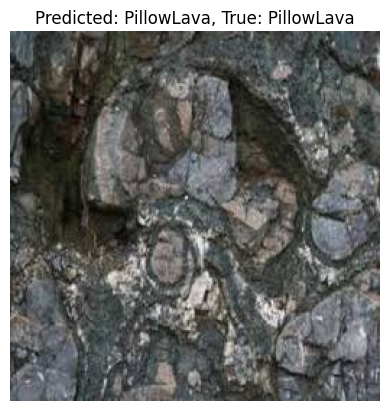

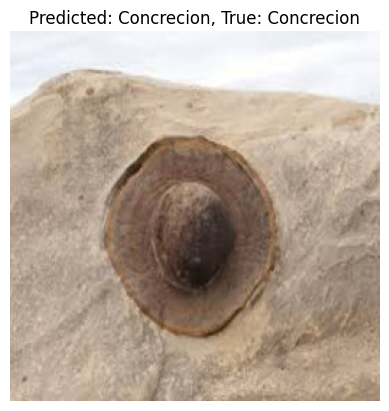

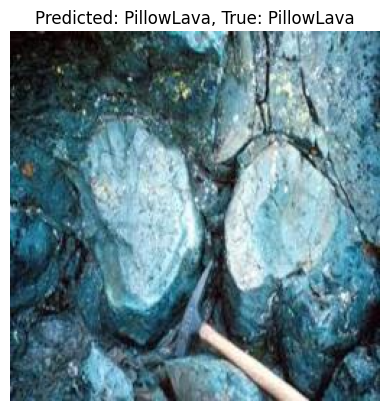

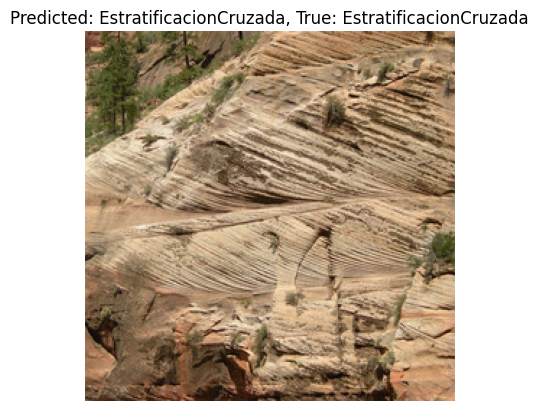

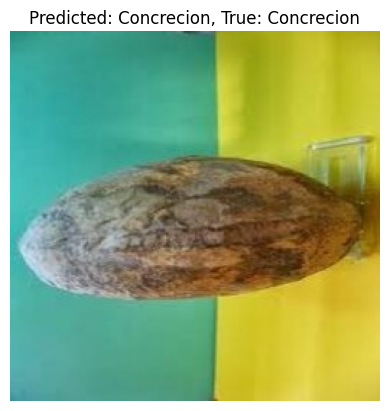

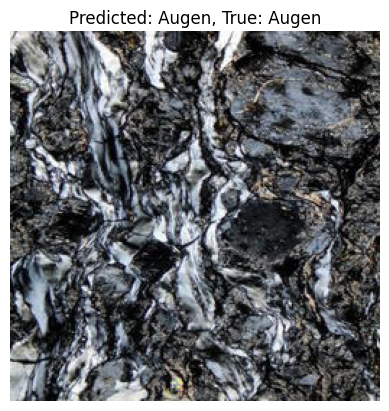

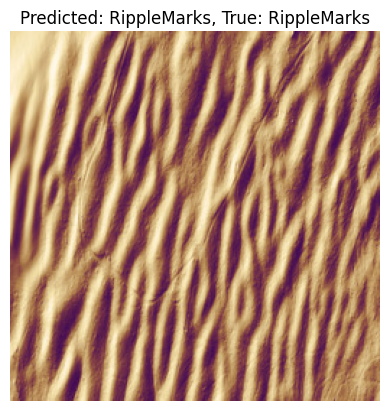

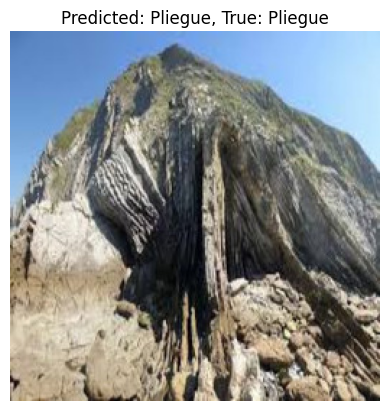

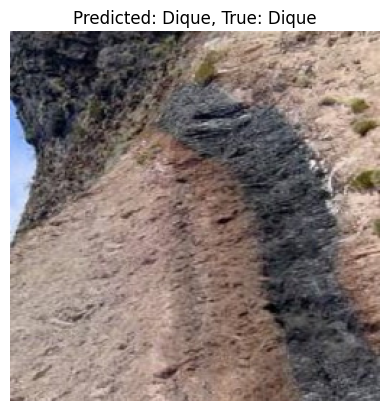

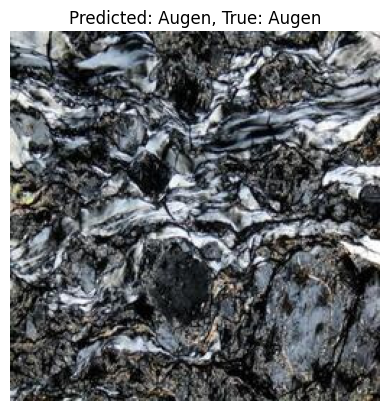

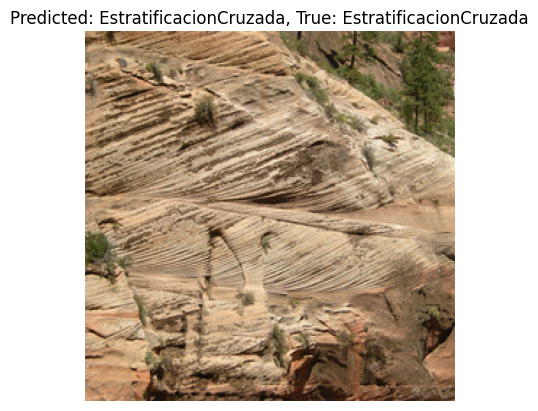

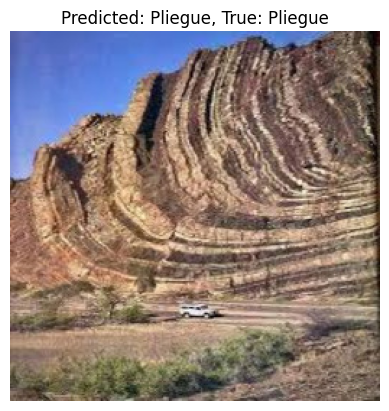

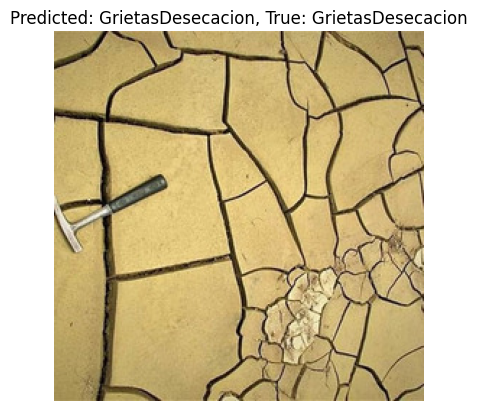

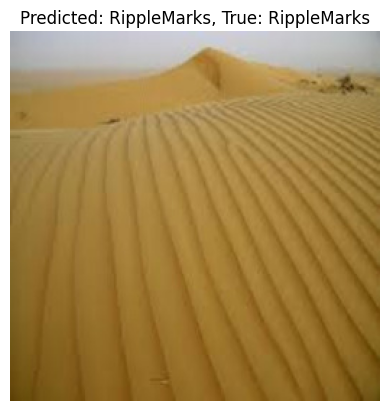

In [86]:
# Mostrar algumas imagens de teste com suas classes preditas e reais
num_images = 15  # Número de imagens para mostrar
sample_indices = np.random.choice(len(test_generator.filenames), num_images, replace=False)
for idx in sample_indices:
    image_path = os.path.join(diretorio_teste, test_generator.filenames[idx])
    image = Image.open(image_path)
    predicted_class = class_labels[predicted_classes[idx]]
    true_class = class_labels[true_classes[idx]]
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}, True: {true_class}')
    plt.axis('off')
    plt.show()

### Rodando os modelos CNN Profunda e Inception com Cross Validation para tentar melhorar mais ainda o resultado.

In [101]:
# Lista para armazenar as métricas de avaliação
accuracy_scores = []

In [102]:
# Pré-processamento dos dados, vou mudar um pouco os valores do treinamento para diversificar mais os dados.
train_datagen = ImageDataGenerator(rescale=1./255,  # Normalização
    rotation_range=30,  # Rotação aleatória de até 30 graus
    width_shift_range=0.3,  # Deslocamento horizontal aleatório
    height_shift_range=0.3,  # Deslocamento vertical aleatório
    shear_range=0.3,  # Cisalhamento aleatório
    zoom_range=0.3,  # Zoom aleatório
    horizontal_flip=True,  # Espelhamento horizontal aleatório
    fill_mode='nearest')  # Modo de preenchimento)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Carregar os dados de treinamento
train_data = train_datagen.flow_from_directory(diretorio_treino,
                                              target_size=(256, 256),
                                              batch_size=batch_size,
                                              class_mode='categorical')

# Carregar os dados de validação
val_data = val_datagen.flow_from_directory(diretorio_validacao,
                                          target_size=(256, 256),
                                          batch_size=batch_size,
                                          class_mode='categorical')

# Carregar os dados de teste
test_data = test_datagen.flow_from_directory(diretorio_teste,
                                            target_size=(256, 256),
                                            batch_size=batch_size,
                                            class_mode='categorical')

Found 1310 images belonging to 9 classes.
Found 360 images belonging to 9 classes.


Found 135 images belonging to 9 classes.


### CNN Profunda com Cross Validation

In [103]:
# Realizar a validação cruzada
kf = KFold(n_splits=3, shuffle=True, random_state=42)
for train_index, val_index in kf.split(os.listdir(diretorio_treino)):
    # Obter os dados de treinamento e validação para o fold atual
    train_data = train_data # Carregar os dados de treinamento usando os índices train_index
    val_data = val_data # Carregar os dados de validação usando os índices val_index

    # Compilar o modelo
    cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Treinar o modelo
    cnn_model.fit(train_data, epochs=epochs, batch_size=batch_size, validation_data=val_data)

    # Avaliar o modelo nos dados de validação
    val_loss, val_accuracy = cnn_model.evaluate(val_data)
    accuracy_scores.append(val_accuracy)

Epoch 1/100
11/11 [==============================] - 10s 851ms/step - loss: 0.9718 - accuracy: 0.6626 - val_loss: 1.2742 - val_accuracy: 0.6194
Epoch 2/100
11/11 [==============================] - 11s 959ms/step - loss: 0.9729 - accuracy: 0.6634 - val_loss: 1.1144 - val_accuracy: 0.6306
Epoch 3/100
11/11 [==============================] - 11s 1s/step - loss: 0.9041 - accuracy: 0.6725 - val_loss: 1.1583 - val_accuracy: 0.6306
Epoch 4/100
11/11 [==============================] - 10s 876ms/step - loss: 0.8992 - accuracy: 0.6840 - val_loss: 1.1198 - val_accuracy: 0.6139
Epoch 5/100
11/11 [==============================] - 9s 821ms/step - loss: 0.8433 - accuracy: 0.7168 - val_loss: 1.0356 - val_accuracy: 0.6417
Epoch 6/100
11/11 [==============================] - 9s 824ms/step - loss: 0.8368 - accuracy: 0.7076 - val_loss: 1.1546 - val_accuracy: 0.6083
Epoch 7/100
11/11 [==============================] - 9s 903ms/step - loss: 0.8638 - accuracy: 0.7069 - val_loss: 1.2824 - val_accuracy: 0.613

In [104]:
# Calcular a média e o desvio padrão das métricas de avaliação
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

# Imprimir os resultados
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Std Accuracy: {std_accuracy}")

Mean Accuracy: 0.734259287516276
Std Accuracy: 0.02618915253190132


In [105]:
# Avaliar o modelo nos dados de teste separados
test_data = test_data # Carregar os dados de teste
test_loss, test_accuracy = cnn_model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy}")

2/2 [==============================] - 0s 18ms/step - loss: 1.0637 - accuracy: 0.7704
Test Accuracy: 0.770370364189148


In [106]:
# Salvar o modelo Inception com Cross Validation
cnn_model.save('D:/Pessoal/Estudos_Pessoais/Pos_Graduacao/Clone_GitHub/Sprint_2/Deep_Learning/Geological_Structures/Models_Train/MVP_Sprint2_Depp_CNN_Cross_Validation.h5')

### InceptionV3 com Cross Validation

In [107]:
# Realizar a validação cruzada
kf = KFold(n_splits=2, shuffle=True, random_state=42)
for train_index, val_index in kf.split(os.listdir(diretorio_treino)):
    # Obter os dados de treinamento e validação para o fold atual
    train_data = train_data # Carregar os dados de treinamento usando os índices train_index
    val_data = val_data # Carregar os dados de validação usando os índices val_index

    # Compilar o modelo
    Inception_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Treinar o modelo
    Inception_model.fit(train_data, epochs=epochs, batch_size=batch_size, validation_data=val_data)

    # Avaliar o modelo nos dados de validação
    val_loss, val_accuracy = Inception_model.evaluate(val_data)
    accuracy_scores.append(val_accuracy)

Epoch 1/100
11/11 [==============================] - 13s 929ms/step - loss: 0.7557 - accuracy: 0.7870 - val_loss: 0.4235 - val_accuracy: 0.8972
Epoch 2/100
11/11 [==============================] - 10s 929ms/step - loss: 0.4994 - accuracy: 0.8542 - val_loss: 0.5772 - val_accuracy: 0.8583
Epoch 3/100
11/11 [==============================] - 10s 874ms/step - loss: 0.4839 - accuracy: 0.8580 - val_loss: 0.5471 - val_accuracy: 0.8944
Epoch 4/100
11/11 [==============================] - 10s 905ms/step - loss: 0.5271 - accuracy: 0.8588 - val_loss: 0.5344 - val_accuracy: 0.8750
Epoch 5/100
11/11 [==============================] - 10s 890ms/step - loss: 0.4963 - accuracy: 0.8458 - val_loss: 0.5679 - val_accuracy: 0.8750
Epoch 6/100
11/11 [==============================] - 10s 992ms/step - loss: 0.5564 - accuracy: 0.8450 - val_loss: 0.5654 - val_accuracy: 0.8972
Epoch 7/100
11/11 [==============================] - 10s 890ms/step - loss: 0.4631 - accuracy: 0.8588 - val_loss: 0.5613 - val_accuracy:

In [108]:
# Calcular a média e o desvio padrão das métricas de avaliação
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

# Imprimir os resultados
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Std Accuracy: {std_accuracy}")

Mean Accuracy: 0.7972222566604614
Std Accuracy: 0.0797372325289822


In [109]:
# Avaliar o modelo nos dados de teste separados
test_data = test_data # Carregar os dados de teste
test_loss, test_accuracy = Inception_model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy}")

2/2 [==============================] - 0s 23ms/step - loss: 0.3970 - accuracy: 0.9333
Test Accuracy: 0.9333333373069763


In [110]:
# Salvar o modelo Inception com Cross Validation
Inception_model.save('D:/Pessoal/Estudos_Pessoais/Pos_Graduacao/Clone_GitHub/Sprint_2/Deep_Learning/Geological_Structures/Models_Train/MVP_Sprint2_Inception_Cross_Validation.h5')